## Reading-in data

First we import the required packages and modules. The last line imports the utility scoring function from the file that was published in Challenge's GitHub page. 

In [26]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import TensorSpec as ts
import pandas as pd
from scipy.special import logit
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

from matplotlib import pyplot as plt 
from tqdm import tqdm, trange
from time import time
from evaluate_sepsis_score import compute_prediction_utility

# the iterative imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


We set up some constants that govern how many CV folds we assume and which CV fold is used for testing, as well as number of batches for mini-batch model fitting.

In [2]:
startTime = time()
dataDir = r"E:\AALTO\Kevät2020\STATISTICAL GENETICS  & PERS. MED\Project\data"
dtype = np.double
reloadDataFlag = False
cvFoldN, cvFold = 5, 0
batchN = 10

Next we import the data from the raw data files, do some truncation for the very outlying outcomes and save the preprocessed data to a single file that is much faster to load.

In [3]:
wspace = 0.5  # the amount of width reserved for space between subplots,
              # expressed as a fraction of the average axis width
hspace = 0.55  # the amount of height reserved for space between subplots,
              # expressed as a fraction of the average axis height
    
if reloadDataFlag:
  subDirList = ["training_setA", "training_setB"]
  dataFrames, P = [], 0
  for subDir in subDirList:
    files = [f for f in os.listdir(os.path.join(dataDir,subDir)) if os.path.isfile(os.path.join(dataDir,subDir, f))]
    for f in tqdm(files):
      df = pd.read_csv(os.path.join(dataDir,subDir,f),sep="|")
      df["Id"] = P
      dataFrames.append(df)
      P += 1
  dataFrame = pd.concat(dataFrames)
      
  fig, axes = plt.subplots(nrows=5, ncols=7, figsize=(20,9))
  for i,ax in enumerate(axes.flatten()):
    q = np.nanquantile(dataFrame.iloc[:,i],[0,0.001,0.01,0.05,0.25,0.5,0.75,0.95,0.99,0.999,1])
    dataFrame.iloc[:,i] = np.clip(dataFrame.iloc[:,i], q[1],q[-2])
    ax.hist(dataFrame.iloc[:,i], bins=10, fc=(0, 1, 0, 1))
    ax.set_title(str(i) + " " + dataFrame.columns[i])
      
      
  plt.subplots_adjust(wspace=wspace, hspace=hspace)
  plt.show()
  
  dataFrame.to_pickle(os.path.join(dataDir,"all_raw_data.pkl"))
else:
  dataFrame = pd.read_pickle(os.path.join(dataDir,"all_raw_data.pkl"))
  P = np.unique(dataFrame["Id"]).shape[0]

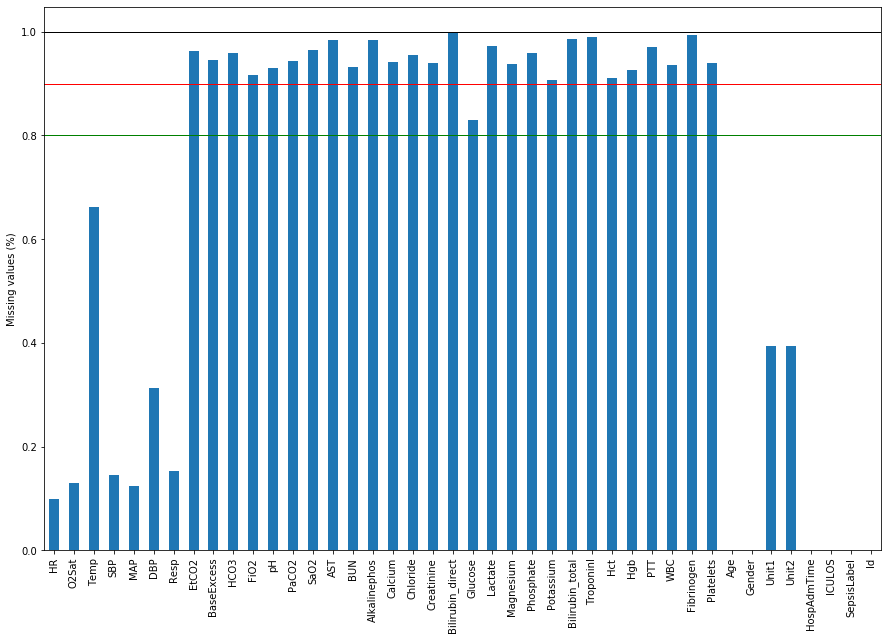

In [4]:
# Calculate the percentage of missing values per feature and plot them

Nan_frame = dataFrame.isna().sum()
N = dataFrame.shape[0]
Nan_frame = Nan_frame/N

ax = Nan_frame.plot.bar(figsize=(15,10))
plt.axhline(y=.8,linewidth=1, color='g')
plt.axhline(y=.9,linewidth=1, color='r')
plt.axhline(y=1,linewidth=1, color='k')
plt.ylabel("Missing values (%)")
path = r"E:\AALTO\Kevät2020\STATISTICAL GENETICS  & PERS. MED\Project\Statistical-Genetics-and-Personalised-Medicine-Assignment\Graphs\missing_values.png"
plt.savefig(path)

Throw away the values that are missing more than 20% and visualize the data. Impute the rest missing values as means of the patient

In [ ]:
# DATA IMPUTATION time~2,5h
    # Does not impute patients with all values nan 
    # -> later replaced with 0
    
Nan_frame = Nan_frame[Nan_frame<0.80]
stripped_frame = dataFrame[Nan_frame.index]

# Join the units as one
stripped_frame["Unit"] = stripped_frame["Unit1"] + 2*stripped_frame["Unit2"] - 1 
stripped_frame.loc[np.isnan(stripped_frame["Unit"]),"Unit"] = 2

stripped_frame=stripped_frame.drop(['Unit1','Unit2'], axis=1)

print(stripped_frame.columns)
print(stripped_frame.shape)

# Impute all nan values of a patient with the mean 
for p in trange(P):
    ROI = stripped_frame[stripped_frame["Id"]==p]
    ROI = ROI.fillna(ROI.mean())
    stripped_frame[stripped_frame["Id"]==p] = ROI

stripped_frame.to_pickle(os.path.join(dataDir,"stripped_filled_data.pkl"))
print("Imputation complete...")

In [5]:
# Strip the most columns (missing>80%) out
Nan_frame = Nan_frame[Nan_frame<0.80]
stripped_frame = dataFrame[Nan_frame.index]

# Join the units as one
stripped_frame["Unit"] = stripped_frame["Unit1"] + 2*stripped_frame["Unit2"] - 1 
stripped_frame.loc[np.isnan(stripped_frame["Unit"]),"Unit"] = 2

stripped_frame=stripped_frame.drop(['Unit1','Unit2'], axis=1)

# Move ID and S.label to last columns
cols = stripped_frame.columns.tolist()
cols = cols[:-3] + cols[-1:] + cols[-3:-1]

stripped_frame = stripped_frame[cols]

print(stripped_frame.columns)
print(stripped_frame.shape)

# Patients that have all nan values in some columns = 19859
# Sepsis patients that have all nan values in some columns = 1644

# Use scikit learn iterative imputer 
    # You could als otry the Knearest imputer -> to all and loads of Neighbours. easy to implement
all_data = stripped_frame.to_numpy()

impute_flag = False
if impute_flag:
    imputer = IterativeImputer(max_iter=10, sample_posterior= True)

    imputed_data = imputer.fit_transform(all_data)
    
    # Save imputed data
    save_imputed = pd.DataFrame(imputed_data, columns=stripped_frame.columns)
    save_imputed.to_pickle(os.path.join(dataDir,"gaus_imputed_data.pkl"))
    print("Imputation saved...")


C:\Users\makke\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\makke\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'Age', 'Gender',
       'HospAdmTime', 'ICULOS', 'Unit', 'SepsisLabel', 'Id'],
      dtype='object')
(1552210, 14)


C:\Users\makke\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\makke\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


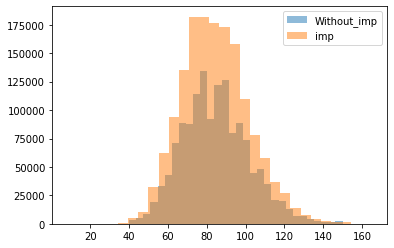

In [6]:
# Download imputed data and plot histograms preimputation and postimputation
imputed_data_frame = pd.read_pickle(os.path.join(dataDir,"gaus_imputed_data.pkl"))

imputed_data= imputed_data_frame.to_numpy()

plt.hist(all_data[:,0], bins=30, alpha=0.5, label='Without_imp')
plt.hist(imputed_data[:,0], bins=30, alpha=0.5, label='imp')
plt.legend(loc='upper right')
plt.show()

In [7]:
# START HERE IF THE DATA HAS BEEN ALREADY RESHAPED
# Divide tha training and testing data
data = imputed_data

# Divide the data to train and test set with both good amount of sepsis patients
all_patients = np.arange(P)


    # ID = -1, Sepsislabel= -2


# Check which patients get sepsis at some point
target_rows =  data[data[:,-2]==1]
id_sepsis_patients = np.unique(target_rows[:,-1])

# The training/testing ratio for sepsis patients 
test_amount_sep = np.rint(0.20*id_sepsis_patients.shape[0])
sepsis_test = np.random.choice(id_sepsis_patients, test_amount_sep.astype(int),replace=False)
sepsis_train = np.setdiff1d(id_sepsis_patients, sepsis_test)

# The trainin/testing ratio for nor sepsis patients
not_sepsis_patients = np.setdiff1d(all_patients, id_sepsis_patients)
test_amount_notsep = np.rint(0.20*not_sepsis_patients.shape[0])
not_sepsis_test = np.random.choice(not_sepsis_patients, test_amount_notsep.astype(int),replace=False)
not_sepsis_train = np.setdiff1d(not_sepsis_patients, not_sepsis_test)

patient_Test = np.concatenate((not_sepsis_test,sepsis_test))
patient_Train = np.setdiff1d(all_patients, patient_Test)

print("The amount of patients who get sepsis: ",id_sepsis_patients.shape[0])
print("The amount of patients who dont get sepsis: ", not_sepsis_patients.shape[0])
print("All patients: ",all_patients.shape[0])
print("Train set: ", patient_Train.shape[0])
print("Test set: ", patient_Test.shape[0])

print("_______")
print("The amount of sepsis patients choosed in test set: ",sepsis_test.shape[0])
print("The amount of sepsis patients choosed in train set",sepsis_train.shape[0])
print("The amount of healthy patients choosed in test set",not_sepsis_test.shape[0])
print("The amount of healthy patients choosed in train set", not_sepsis_train.shape[0])



# Make masks to get the training and testing sets
indTrain = np.isin(data[:,-1], patient_Train)
indTest = np.isin(data[:,-1], patient_Test)
data_Train = data[indTrain]
data_Test = data[indTest]

# Get the X and y for train and test
    # REMEMBER NOT TO INPUT ID TO NETWORK!!!
    # ID = -1, Sepsislabel= -2
X_train = data_Train
X_test = data_Test

# Scale (normalize) X_train 
    # XScale = [2,12]
XScale = np.array([np.nanmean(X_train[:,:-2],0),np.nanstd(X_train[:,:-2],0)])
XScale[:,-1] = [0,1]
XScale[0,0] = 0

X_train_scaled = X_train
X_train_scaled[:,:-2] = (X_train_scaled[:,:-2] - XScale[0]) / XScale[1]
X_test_scaled = X_test
X_test_scaled[:,:-2] = (X_test_scaled[:,:-2] - XScale[0]) / XScale[1]

Data_Train = X_train_scaled
Data_Test = X_test_scaled



The amount of patients who get sepsis:  2932
The amount of patients who dont get sepsis:  37404
All patients:  40336
Train set:  32269
Test set:  8067
_______
The amount of sepsis patients choosed in test set:  586
The amount of sepsis patients choosed in train set 2346
The amount of healthy patients choosed in test set 7481
The amount of healthy patients choosed in train set 29923


In [83]:
# The paramters for the model
epochs = 1
time_steps = 3
# -2 as ID is not feature and sepsis label has already been removed
n_features = X_train.shape[1]-2
early_stop = 0.05 

# Parameters for the loss function
dt_early   = -12
dt_optimal = -6
dt_late    = 3


In [81]:
# Function to reshape the data for the network
def split_sequences(sequences,n_steps):
    """
    Input:  Sequences = the data of one patient
            n_steps = the screening window size 
    
    returns X and y in the form of 
    X:(m_batch,time_step,num_features)
    Y:(m_batch,time_step,1)
    """
    # Delete the patient id 
    sequences = np.delete(sequences, -1, axis=1) 
    
    X,y=list(),list()
    for i in range(len(sequences)-n_steps+1):
        end_ix = i + n_steps
        
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X), np.array(y)

# 
    - calculate optimal utilities for the patient and use them to get the
        - cant use, need to figure out another way to calculate the loss
- norm_U
    - loss = 1-norm_U
    - custom training 
    

In [69]:
# The loss function based on the given utility function
    # maximise normed utility = minimise (1- normed utility)

'''
output shape = [time_steps-window, 1]
labels shape = [time_steps, 1]
'''
def own_loss(labels, output):
    
    # Set the values to 1/0 in predictions and pad the beginning
    pred_mask = outputs > 0.5
    pred_mask = np.pad(pred_mask, ((time_steps,0),(0,0)), 'edge')
    
    # The calculations for the optimal predictions
    N = labels.shape[0]
    best_predictions = np.zeros(N)
    inaction_predictions = np.zeros(N)
    action_predictions = np.ones(N)
    if np.any(labels):
      # Optimal prediction time is the period of 6 hours after first 1 in sepsilabel  
      t_sepsis = np.argmax(labels) - dt_optimal
      # The best prediction times for the patient
      best_predictions[max(0, t_sepsis + dt_early) : min(t_sepsis + dt_late + 1, N)] = 1

    # The utility of the prediction
    observed_utilities ,_ = compute_prediction_utility(labels, output)
    # The best possible utility
    best_utilities ,_ = compute_prediction_utility(sep_label_vec, best_predictions)
    # The non-trivial utility
    inaction_utilities ,_ = compute_prediction_utility(sep_label_vec, inaction_predictions)
    
    unnormalized_observed_utility = np.sum(observed_utilities)
    unnormalized_best_utility     = np.sum(best_utilities)
    unnormalized_inaction_utility = np.sum(inaction_utilities)
    
    # Calculate the loss [0,1], smaller the loss, bigger the utility
    normalized_observed_utility = (unnormalized_observed_utility - unnormalized_inaction_utility) / (unnormalized_best_utility - unnormalized_inaction_utility)
    loss = 1 - normalized_observed_utility
    
    return loss

@tf.function
def tf_own_loss(labels, output):
    loss = tf.py_function(own_loss, inp=[labels,output], Tout=[tf.float64])
    return loss

In [13]:
# The LSTM-model in KERAS (1st try)
LSTM_model = tf.keras.Sequential()

LSTM_model.add(tf.keras.layers.LSTM(units=100,input_shape=(time_steps,n_features),return_sequences=True))
LSTM_model.add(tf.keras.layers.Dropout(0.2))

LSTM_model.add(tf.keras.layers.LSTM(units=100,return_sequences=True))
LSTM_model.add(tf.keras.layers.Dropout(0.2))

LSTM_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(25,activation='relu')))
LSTM_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1,activation='sigmoid')))

adam = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.)
LSTM_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])


In [82]:
# The SIMPLER LSTM-model  (2st try)
LSTM_model_2 = tf.keras.Sequential()

LSTM_model_2.add(tf.keras.layers.LSTM(units=128,input_shape=(time_steps,n_features)))

LSTM_model_2.add(tf.keras.layers.Dense(1,activation='sigmoid'))

adam = tf.keras.optimizers.Adam(learning_rate=0.001)

LSTM_model_2.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])


In [79]:
LSTM_model_2.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 128)               72192     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 129       
Total params: 72,321
Trainable params: 72,321
Non-trainable params: 0
_________________________________________________________________


In [84]:
random.shuffle(patient_Train)
random.shuffle(patient_Test)

with tqdm(patient_Train) as patient:
    for e in range(epochs):
        print("EPOCH: ", e)
        patient.reset()
        for p in patient:
            p_sequence = Data_Train[Data_Train[:,-1]== p]
            x,y = split_sequences(p_sequence,time_steps) 

            batch_loss, batch_acc = LSTM_model_2.train_on_batch(x,y)

            patient.set_postfix(epoch="%.3d"%p, loss="%01.3f"%batch_loss, accuracy="%01.3f"%batch_acc)

        # Check for overfitting

  0%|                                                                                        | 0/32269 [00:00<?, ?it/s]

EPOCH:  0


100%|███████████████████████████████████| 32269/32269 [10:19<00:00, 52.11it/s, accuracy=1.000, epoch=31680, loss=0.021]


In [33]:
#SKIP IF DO NOT WANT TO SPLIT AGAIN!!
## Reshape train datasets to usable form time~2h

# Shuffle the patient_Train so all sepsis patients are not at the end
random.shuffle(patient_Train)

for idx,p in enumerate(tqdm(patient_Train)):
    p_sequence = Data_Train[Data_Train[:,-1]== p]
    x,y = split_sequences(p_sequence,time_steps) 
    
    if idx == 0:
        Input_train = x
        Label_train = y
    else:
        Input_train = np.concatenate((Input_train,x), 0)
        Label_train = np.concatenate((Label_train,y), 0)
       
print("Iterated through patients: ", idx+1)
np.save(dataDir+"\input_train_w6.npy",Input_train)
np.save(dataDir+"\label_train_w6.npy",Label_train)
    


 14%|███████████                                                                  | 4630/32269 [03:20<19:56, 23.11it/s]


KeyboardInterrupt: 

In [73]:
#SKIP IF DO NOT WANT TO SPLIT AGAIN!!
## Reshape test datasets to usable form time~10min
for idx,p in enumerate(tqdm(patient_Test)):
    p_sequence = Data_Test[Data_Test[:,-1]== p]
    x,y = split_sequences(p_sequence,time_steps) 
    if idx == 0:
        Input_test = x
        Label_test = y
    else:
        Input_test = np.concatenate((Input_test,x), 0)
        Label_test = np.concatenate((Label_test,y),0)
    
print("Iterated through patients: ", idx+1)
np.save(dataDir+"\input_test_w3.npy",Input_test)
np.save(dataDir+"\label_test_w3.npy",Label_test)


100%|██████████████████████████████████████████████████████████████████████████████| 8067/8067 [06:59<00:00, 19.24it/s]


Iterated through patients:  8067


In [74]:
# The train loop for the LMST- model
Input_train = np.load(dataDir+"\input_train.npy") 
Label_train = np.load(dataDir+"\label_train.npy") 
Input_test = np.load(dataDir+"\input_test_w3.npy") 
Label_test = np.load(dataDir+"\label_test_w3.npy") 

In [15]:
# Lets see how the model performs if we change all nans to 0
Input_train_non =np.nan_to_num(Input_train) 
Input_test_non = np.nan_to_num(Input_test)

# Fit the model using training data
history = LSTM_model.fit(Input_train_non, Label_train, batch_size=128, epochs=epochs)
print("Model trained...")

# Evaluate the model using test data
results = LSTM_model.evaluate(Input_test_non, Label_test, batch_size=128)
print('test loss, test acc:', results)

LSTM_model.save_weights(dataDir+"\model_weights")


Train on 1018153 samples
Epoch 1/2
1018153/1018153 [==============================] - 205s 201us/sample - loss: 0.0606 - accuracy: 0.9876
Epoch 2/2
1018153/1018153 [==============================] - 200s 196us/sample - loss: 0.0577 - accuracy: 0.9876
Model trained...
251705/251705 [==============================] - 16s 64us/sample - loss: 0.0581 - accuracy: 0.9876
test loss, test acc: [0.058067057221332846, 0.9876314]


In [87]:
# Create the prediction matrix 
    # Loop through the patients and predict separately for each patient

    # Sum time window probabilities and find first value that is over 2.4 (change it later)
    
    
pred = []
observed_utilities = np.zeros([patient_Test.shape[0]])

for idx,p in enumerate(tqdm(patient_Test)):
    #p_sequence = np.nan_to_num(Data_Test[Data_Test[:,-1]== p])
    p_sequence = Data_Test[Data_Test[:,-1]== p]
    
    sep_label = p_sequence[:,-2]
    
    x,y = split_sequences(p_sequence,time_steps) 
    
    p_predictions = LSTM_model_2.predict(x)
    # Instead of this take last value and pad the first values
    p_pred_sum = p_predictions[:,-1]
                
    # Might still exist local minimums that stay false
    pred_mask = p_pred_sum > 0.5
    
    # Difference in length
    diff = p_sequence.shape[0] - pred_mask.shape[0] 
    # Pad the prediction with the edge value
    pred_mask = np.pad(pred_mask, (diff,0), 'edge')
    #pred.append(pred_mask)
    
    observed_utilities[idx],_ = compute_prediction_utility(sep_label, pred_mask)
    
#print(len(pred))
#print(pred_mask.shape)
#print(p_sequence.shape)
#print(pred_mask)
#print(p_sequence)
print(observed_utilities.shape)
  

100%|██████████████████████████████████████████████████████████████████████████████| 8067/8067 [03:48<00:00, 35.31it/s]

(8067,)


Following the scoring rules of the Challenge, we compute the utility of trivial (inaction) predictions and optimal predictions. Those are used to get a score that shall be within the range $[0,1]$.

In [88]:
dt_early   = -12
dt_optimal = -6
dt_late    = 3

testN = patient_Test.shape[0]
best_utilities     = np.zeros(testN)
inaction_utilities = np.zeros(testN)


#with tqdm(range(testN)) as progressBar:
  #for indTest in progressBar:
    
for idx,p in enumerate(tqdm(patient_Test)):
    #patient_sequence = np.nan_to_num(Data_Test[Data_Test[:,-1]== p])
    patient_sequence = Data_Test[Data_Test[:,-1]== p]
    sep_label_vec = patient_sequence[:,-2]
    
    #idTest = idVecTest[indTest]

    #indIdTest = np.where(XTest[:,-1] == idTest)[0]

    #XTestId,YTestId = XTest[indIdTest,:-1].copy(), YTest[indIdTest].copy()

    #sepLabelVec = ~np.isnan(XTestId[:,0]) * (XTestId[:,0]>=0.0)
    
    N = patient_sequence.shape[0]
    best_predictions     = np.zeros(N)
    inaction_predictions = np.zeros(N)
    action_predictions = np.ones(N)
    if np.any(sep_label_vec):
      # Optimal prediction time is the period of 6 hours after first 1 in sepsilabel  
      t_sepsis = np.argmax(sep_label_vec) - dt_optimal
      # The best prediction times for the patient
      best_predictions[max(0, t_sepsis + dt_early) : min(t_sepsis + dt_late + 1, N)] = 1
    # Save the best utilities for do-something and do-nothing (?)
    best_utilities[idx],_ = compute_prediction_utility(sep_label_vec, best_predictions)
    inaction_utilities[idx],_ = compute_prediction_utility(sep_label_vec, inaction_predictions)
unnormalized_best_utility     = np.sum(best_utilities)
unnormalized_inaction_utility = np.sum(inaction_utilities)

100%|█████████████████████████████████████████████████████████████████████████████| 8067/8067 [00:27<00:00, 291.78it/s]


Finally, we print the predictive score for the current CV fold.

In [89]:
unnormalized_observed_utility = np.sum(observed_utilities)
normalized_observed_utility = (unnormalized_observed_utility - unnormalized_inaction_utility) / (unnormalized_best_utility - unnormalized_inaction_utility)
print("\nPredictive utility score %.3f, elapsed time %ds"%(normalized_observed_utility, time() - startTime))


Predictive utility score 0.000, elapsed time 17336s


This example with linear model ends up in somewhat $0.03$ utility score if we average over the 5 CV folds. This is very far behind the methods from the top of the leaderboard, but still better than the best trivial predictions. However, this is why this model is marked as number 1, so the other onces shall generally perform better. Also, remember that you are not requested to beat them, but rahter conducting a course project that is aimed to give you practical skills on multivariate generative modelling that would be applicable in a wide range of biomedical applications.



## NOTES

The predictions have ~8hour window of no predictions in the end of each patient. -> how to deal with that? 
    - Pad the last prediction value to the end. The network should be able to classify right the last label at least

Predictive utility 0.009, 0.017


# Enjoy the exciting dataset and good luck!